# MAY CONTAIN ERRORS
Please note that I moved all parameters in $\Delta$ at once, not one by one, which makes results worse when we have more than six or seven dimensions.

In [1]:
%matplotlib inline

Useful:
* Bayesian Inference for a Covariance Matrix (Ignacio Alvarez, Jarad Niemi, and Matt Simpson)

* O'Malley and Zaslavsky (2008). They have decomposed the covariance matrix as $\Sigma = \Delta\Phi\Delta$; $\Delta$ is a diagonal matrix of $\delta_i$ and $\log(\delta_i) \sim \mathcal{N}(m,s)$; $\Phi$ is a correlation matrix, $\Phi \sim IW(nu,I)$.
* In order to update the $\delta_i$ they used Metropolis Hasting step where the proposal distribution is the logarithm of a t distribution with 3 degrees of freedom.

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
import collections
npr.seed(225)

In [3]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5.5, 3.5

# Create Data

In [4]:
N = 100 # number of data
D = 5 # dimensions
max_mean = 0.8
max_cov = 0.15

mean_vec = npr.normal(max_mean/2, 1, D)
cov_mat = sps.invwishart.rvs(D+1, npr.uniform(max_cov/2, max_cov, D) )
data = npr.multivariate_normal(mean_vec, cov_mat, N)

# Iterations

In [5]:
iter_num = 2500
show_num = 1800

# Prepare priors
## mean
mu_0 = np.repeat(0, D)
cov_0 = np.diag(np.repeat(0.5, D))

## cov
nu = D + 1
psi = np.identity(D)
delta = np.identity(D)

# Initialization
mean_itr = npr.uniform(0, max_mean*2, D)
sigma_itr = sps.invwishart.rvs(nu, psi)
cov_itr = delta.dot(sigma_itr).dot(delta)

# store_delta
delta_proposed = np.zeros((D,D))

In [6]:
def mvn_loglik_single(x, mu, cov):
    loglik = -0.5 * ( (x - mu).dot( np.linalg.inv(cov) ).dot((x-mu).transpose()) ) - 0.5 * np.log( np.linalg.det(2.0 * np.pi * cov ) )
    return loglik
def mvn_loglik(x, mu, cov):
    num = x.shape[0] 
    if num == 1:
        return mvn_loglik_single(x, mu, cov)
    else:
        loglik = 0.0
        for i in range(num):
            loglik += mvn_loglik_single(data[i], mean_vec, cov_mat)
    
    return loglik

In [7]:
# Iteration
mean_chain = []
cov_chain = []
accept = 0
for i in range(iter_num):
    # Update mean
    cov0_inv = np.linalg.inv(cov_0)
    cov_inv = np.linalg.inv(cov_itr)
    cov_tmp = np.linalg.inv( cov0_inv  + N * cov_inv )
    mean_tmp = cov_tmp.dot( cov0_inv.dot(mu_0) + N * np.dot(cov_inv,  data.mean(axis=0)) )
    mean_itr = npr.multivariate_normal(mean_tmp, cov_tmp, 1)

    mean_chain.append(mean_itr[0])

    # Update delta (update all at the same time)
    for k in range(D):
        delta_proposed[k,k] = delta[k,k] * np.exp( npr.normal(0, 0.02) )
    cov_proposed = delta_proposed.dot(sigma_itr).dot(delta_proposed)
        
    diflikelihood = mvn_loglik(data, mean_itr, cov_proposed) - mvn_loglik(data, mean_itr, cov_itr)
    for k in range(D):
        # consider prior
        diflikelihood += sps.gamma.pdf(delta_proposed[k,k], a=2.0, scale=2.0) - sps.gamma.pdf(delta[k,k], a=2.0, scale=2.0)
        
    r = min(0, diflikelihood) # np.log(1) = 0
    u = np.log(npr.uniform(0,1))

    if u < r:
        accept  += 1
        delta = delta_proposed
    else:
        pass
        
        
    # Update cov
    data_demean = data - mean_itr
    scale_tmp = psi + np.linalg.inv(delta).dot( (data_demean.transpose()).dot(data_demean) ).dot(np.linalg.inv(delta))

    sigma_itr = sps.invwishart.rvs(N-1, scale_tmp)

    cov_itr = delta.dot(sigma_itr).dot(delta)
    cov_chain.append(cov_itr)
    

mean_chain = np.array(mean_chain)
cov_chain = np.array(cov_chain)

accept / iter_num

1.0

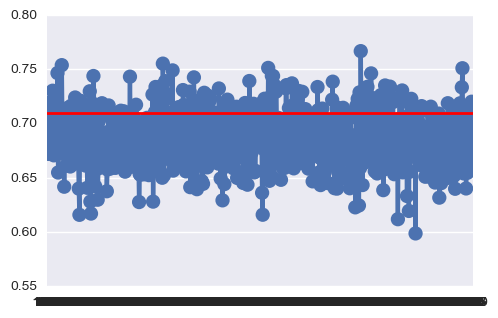

In [8]:
dim = 0
sns.pointplot(x=np.arange(show_num, iter_num, 1), y=mean_chain[show_num: , dim])
plt.plot([0, iter_num-show_num], [mean_vec[dim], mean_vec[dim]], linewidth=2, color='red')

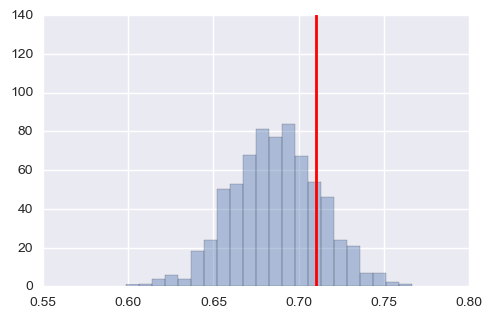

In [9]:
dim = 0
sns.distplot(mean_chain[show_num: , dim], hist=True, kde=False)
plt.plot([mean_vec[dim], mean_vec[dim]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

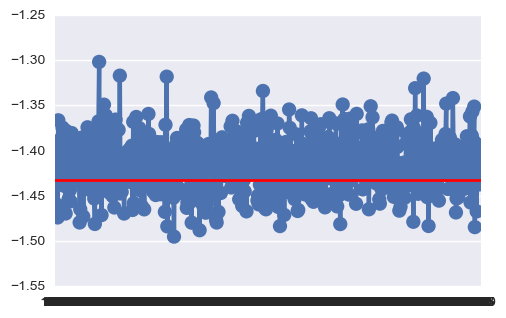

In [10]:
dim = 1
sns.pointplot(x=np.arange(show_num, iter_num, 1), y=mean_chain[show_num: , dim])
plt.plot([0, iter_num-show_num], [mean_vec[dim], mean_vec[dim]], linewidth=2, color='red')

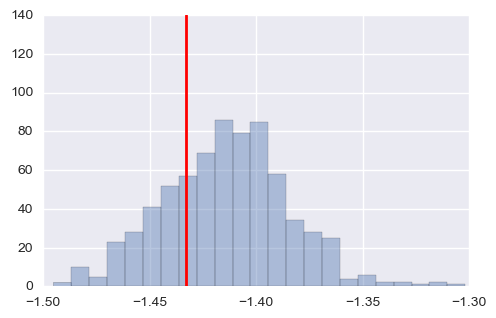

In [11]:
dim = 1
sns.distplot(mean_chain[show_num: , dim], hist=True, kde=False)
plt.plot([mean_vec[dim], mean_vec[dim]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

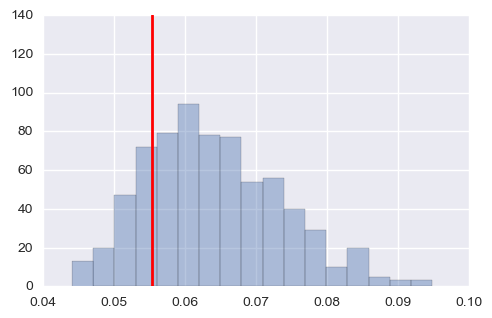

In [12]:
index = (0,0)
sns.distplot(cov_chain[show_num:, index[0], index[1]], hist=True, kde=False)
plt.plot([cov_mat[index[0], index[1]], cov_mat[index[0], index[1]]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

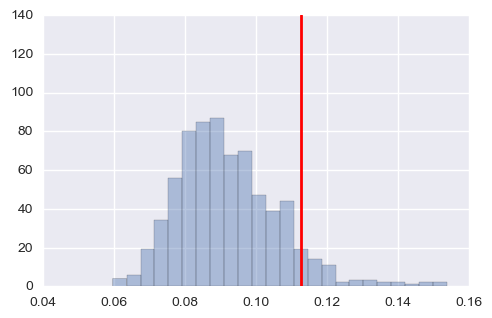

In [13]:
index = (1,1)
sns.distplot(cov_chain[show_num:, index[0], index[1]], hist=True, kde=False)
plt.plot([cov_mat[index[0], index[1]], cov_mat[index[0], index[1]]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

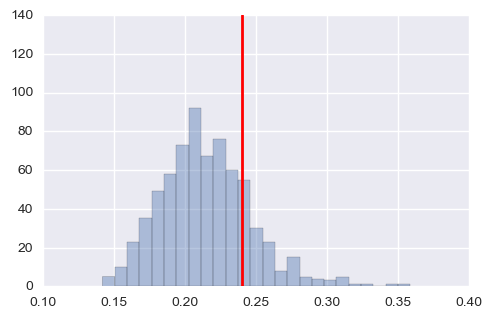

In [14]:
index = (2,2)
sns.distplot(cov_chain[show_num:, index[0], index[1]], hist=True, kde=False)
plt.plot([cov_mat[index[0], index[1]], cov_mat[index[0], index[1]]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

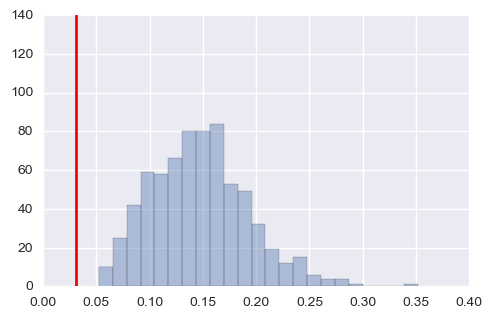

In [15]:
index = (3,3)
sns.distplot(cov_chain[show_num:, index[0], index[1]], hist=True, kde=False)
plt.plot([cov_mat[index[0], index[1]], cov_mat[index[0], index[1]]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')

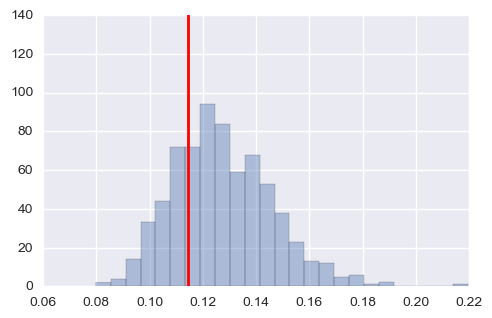

In [16]:
index = (4,4)
sns.distplot(cov_chain[show_num:, index[0], index[1]], hist=True, kde=False)
plt.plot([cov_mat[index[0], index[1]], cov_mat[index[0], index[1]]], [0, (iter_num-show_num)*0.2], linewidth=2, color='red')